# Convolutional Neural Network

In this tutorial, we will build a convolutional neural network.

In short, the differences to a feedforward neural network are not too big, the difference is that with images we usually have a large input space (width x length) and the spatial position _matters_. We would not recognize an image whose pixels are randomly shuffled.

Therefore, convolutions and pooling is used. This corresponds to a filter ("mini image consisting of 3x3 - 5x5 pixels) scanning over the whole image and returning a value proportional to "how well the mini image fits".

For a more in depth explanation


First we do some imports

In [39]:
import pandas, keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from IPython.display import FileLink, FileLinks

We get our data that is stored in the cloud. Using the link inside a browser, we can also download the data to our local machine.

In [ ]:
# downloading the data
!wget "https://drive.switch.ch/index.php/s/xcLDFKJAyyZGmfD/download" -O train_img.h5

Loading the data and some dimensional preprocessing

In [40]:
# 1 image has 40x40 pixels = 1600 pixels
pixels = ["img_{0}".format(i) for i in range(1600)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,40,40), axis=-1)


# Read the first 10k events
store_train = pandas.HDFStore("train_img.h5")
df_train = store_train.select("table")
images_train = to_image(df_train)

## Visualizing the data

In [51]:
# simple helper function
def plot_image(number):
    plt.imshow(images_train[number, :, :, 0])

We can look at the images that we gonna train on

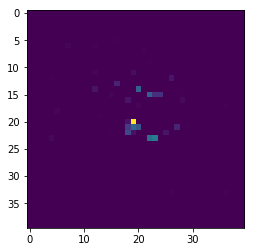

In [52]:
plot_image(10)  # put any number here you want to see

## Maxpooling

<img src="imgs/maxpool_animation.gif">

front.png  maxpool_animation.gif  side.png


In [38]:
# Define the network
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='tanh', 
          input_shape=(40,40,1),data_format = "channels_last"))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation='tanh'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation='tanh'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2, activation='softmax'))
print(model.summary())
                                                    
# Train the network
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])
model.fit(images_train, keras.utils.to_categorical(df_train["is_signal_new"]), epochs=100, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
flatten_5 (Flatten)          (None, 46208)             0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 46208)             184832    
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2310450   
_________________________________________________________________
batch_normalization_14 (Batc (None, 50)                200       
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_15 (Batc (None, 50)                200       
__________

KeyboardInterrupt: 

In [ ]:
### Evaluate performance on independent sample
# DO NOT CHANGE BELOW!

# Prepare input
store_test = pandas.HDFStore("test_without_truth_img_100k.h5")
df_test = store_test.select("table")
images_test = to_image(df_test)

# Run DNN
print("Running on full test sample. This may take a moment.")
ret = model.predict(images_test)
np.save("result.npy",ret[:,1])
!zip result.zip result.npy
print("Done. Click below  to download result")
FileLink('result.zip')